In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
#import tensorflow as tf
import keras
from keras.utils import multi_gpu_model
import tensorflow as tf
from temnn.knet import net
#from temdata.dataset import DataEntry,DataSet
from temnn.net.dataset import DataEntry,DataSet
from pyqstem.imaging import CTF
import matplotlib.pyplot as plt
# Peak detection
from stm.preprocess import normalize
from stm.feature.peaks import find_local_peaks, refine_peaks
from skimage.morphology import disk
from scipy.spatial import cKDTree as KDTree
import sys
import os
from collections import deque
from multiprocessing import Pool

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Data folders
data_dir = "data/cluster-110-single-class/"
#validation_dir = "data/cluster-110-single-class-test/"
validation_dir = data_dir  # A big no-no
graph_dir = 'graphs-initial'
graph_path = os.path.join(graph_dir, 'clusters-{:d}.h5')


In [3]:
# Microscope parameters
#sampling=0.11953 #244.8/2048
sampling=0.10
Cs=-10e4
defocus=90
focal_spread=30
blur=1.5
#dose=5*10**2
dose = 5e2
mtf_param=[1,0,4.89683027e-01,2.34644273e+00]

In [4]:
num_gpus = 1
batch_size = 8 * num_gpus

In [5]:
def load(data_dir):
    "Load data folder."
    #models=sorted(glob(data_dir+"model/model_*.cfg"))
    waves=sorted(glob(data_dir+"wave/wave_*.npz"))
    #labels=sorted(glob(data_dir+"label/label_*.npy"))
    points=sorted(glob(data_dir+"points/points_*.npz"))
    #entries=[DataEntry(model,wave,label) for model,wave,label in zip(models,waves,labels)]
    entries = [DataEntry(wave=w, points=p) for w,p in zip(waves,points)]

    return DataSet(entries)

In [6]:
def load_CNN(graph_path, size, num_gpus=1):
    "Load the Keras neural net, and return a Model."
    kernel_num=32
    image_features=1
    num_classes=1

    if num_gpus == 1:
        x = keras.Input(shape=size+(image_features,))
        model = net.graph(x, output_features=num_classes)
        model.load_weights(graph_path)
    else:
        with tf.device('/cpu:0'):
            x = keras.Input(shape=size+(image_features,))
            model = net.graph(x, output_features=num_classes)
            model.load_weights(graph_path)
        model = multi_gpu_model(model, gpus=num_gpus)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    
    return (x, model)

In [7]:
def makeimage(entry, size):
    entry.load()    
    ctf=CTF(defocus=defocus,Cs=Cs,focal_spread=focal_spread)
    entry.create_image(ctf,sampling,blur,dose,mtf_param)
    entry.create_label(sampling, width = int(.4/sampling), num_classes=False)

    entry.local_normalize(12./sampling, 12./sampling)
    shape = entry._image.shape[1:3]
    assert not ((size[0] > shape[0]) != (size[1] > shape[1]))
    if shape[0] > size[1]:
        assert shape[1] >= size[1]
        entry.random_crop(size, sampling)
    elif shape[0] < size[1]:
        assert shape[1] <= size[1]
        entry.pad(size)
    else:
        assert shape[1] == size[1]

    image,label=entry.as_tensors()
    entry.reset()
    
    return image, label

# Use multiprocessing to generate many sample datasets
class MakeImages:
    def __init__(self, data, imagesize):
        self.data = data
        self.precomputed = []
        self.batchsize = 10
        self.imagesize = np.array(imagesize)

    def precompute(self):
        #print("Precomputing {} images.".format(self.batchsize), flush=True)
        entries = self.data.next_batch(self.batchsize, shuffle=False)
        imagesizes = self.imagesize[np.newaxis,:] * np.ones(self.batchsize, int)[:,np.newaxis]
        with Pool() as pool:
            self.precomputed = deque(pool.starmap(makeimage,  zip(entries, imagesizes)))

    def next_example(self):
        if not self.precomputed:
            self.precompute()
        return self.precomputed.popleft()

    def get_all_examples(self):
        "Get an example from each data point."
        n = self.data.num_examples
        entries = self.data.next_batch(n, shuffle=False)
        imagesizes = self.imagesize[np.newaxis,:] * np.ones(n, int)[:,np.newaxis]
        images = []
        labels = []
        with Pool() as pool:
            for img, lbl in pool.starmap(makeimage, zip(entries, imagesizes)):
                images.append(img)
                labels.append(lbl)
        return np.concatenate(images), np.concatenate(labels)

In [8]:
def precision_recall(predicted, target, distance=5.0):
    """Precision and recall for peak positions"""
    # Precision: Number of correctly predicted peaks 
    # divided by number of target peaks
    if len(predicted) == 0:
        return (0.0, 1.0)
    if len(target) == 0:
        return (1.0, 0.0)
    tree = KDTree(target)
    x = tree.query(predicted, distance_upper_bound=distance)[0]
    precision = (x <= distance).sum() / len(predicted)
    # Recall: Number of target peaks that were found
    # divided by total number of target peaks
    tree = KDTree(predicted)
    x = tree.query(target, distance_upper_bound=distance)[0]
    recall = (x <= distance).sum() / len(target)
    return (precision, recall)

def evaluate_result(inference, label):
    "Evaluate the prediction for an image."
    # Find the peaks
    infer_peaks = find_local_peaks(inference[:,:,0], min_distance=25, 
                                   threshold=0.6, exclude_border=10,
                                   exclude_adjacent=True)
    label_peaks = find_local_peaks(label[:,:,0], min_distance=25, 
                                   threshold=0.6, exclude_border=10,
                                   exclude_adjacent=True)

    # Refine the peaks
    region = disk(2)
    infer_refined = refine_peaks(normalize(inference[:,:,0]), infer_peaks, 
                                region, model='polynomial')
    label_refined = refine_peaks(normalize(label[:,:,0]), label_peaks, 
                                region, model='polynomial')
    precision, recall = precision_recall(infer_refined, label_refined)
    return (precision, recall, infer_refined, label_refined)

## The action starts here !

In [9]:
image_size = (360,360)
data_train = load(data_dir)
imagestream_train = MakeImages(data_train, image_size)
n_train = data_train.num_examples
print("Number of training images:", n_train)

Number of training images: 1000


In [10]:
# Find the latest CNN
print("Looking for CNNs in files matching", graph_path)
i = 1
while os.path.exists(graph_path.format(i)):
    gr = graph_path.format(i)
    i += 1
print("Using CNN parameters in", gr)
x, model = load_CNN(gr, image_size, num_gpus)

Looking for CNNs in files matching graphs-initial/clusters-{:d}.h5
Using CNN parameters in graphs-initial/clusters-19.h5


In [11]:
n = n_train
imagestream = imagestream_train

In [12]:
image, label = imagestream.next_example()
print(image.shape, label.shape)
predictions = model.predict(image)
print(predictions.shape)

(1, 360, 360, 1) (1, 360, 360, 1)
(1, 360, 360, 1)


Peaks in labels 118
Peaks in prediction 3
Precision, recall 1.0 0.025423728813559324


/Users/schiotz/development/structural-template-matching/build/lib.macosx-10.13-x86_64-3.6/stm/feature/fitting.py:56: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  p, residues, rank, singval = np.linalg.lstsq(v.T, z)


(-0.5, 359.5, 359.5, -0.5)

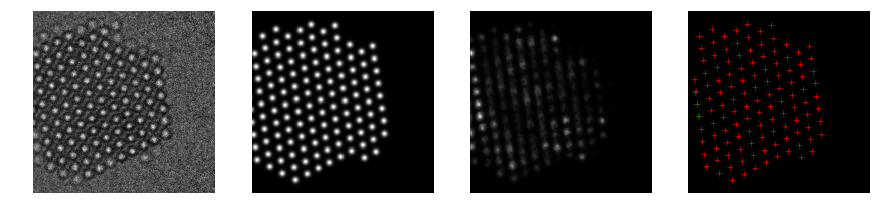

In [13]:
prec, rec, pred_pos, lbl_pos = evaluate_result(predictions[0],label[0])
print("Peaks in labels", len(lbl_pos))
print("Peaks in prediction", len(pred_pos))
print("Precision, recall", prec, rec)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(15,4))
im1 = ax1.imshow(image[0,:,:,0].T,cmap='gray')
im2 = ax2.imshow(label[0,:,:,0].T,cmap='gray')
im3 = ax3.imshow(predictions[0,:,:,0].T,cmap='gray')
ax4.imshow(np.zeros_like(image)[0,:,:,0].T, cmap='gray')
ax4.scatter(lbl_pos[:,0], lbl_pos[:,1], c='r', marker='+', linewidth=.6)
ax4.scatter(pred_pos[:,0], pred_pos[:,1], c='g', marker='+', linewidth=.6)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')